# Imports

In [104]:
## uncomment all this if you want to run this file locally
# %pip install transformers
# %pip install torch
# %pip install pandas
# %pip install numpy
# %pip install scikit-learn
# %pip install seaborn
# %pip install matplotlib
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install "accelerate>=0.26.0"
# %pip install ipywidgets
# %pip install sentencepiece

In [105]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from transformers import XLMRobertaTokenizer, AutoTokenizer, Trainer, AutoModelForSequenceClassification, TrainingArguments

import os

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torch import nn
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

#from google.colab import drive
import matplotlib.pyplot as plt



In [106]:
# Check if  is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3060


# Data loading and processing

In [107]:
sesotho_tweets_url = 'https://raw.githubusercontent.com/Khotso-Bore/neural-languange-model/refs/heads/main/sesotho_tweets.csv'
sesotho_headlines_url = 'https://raw.githubusercontent.com/Khotso-Bore/neural-languange-model/refs/heads/main/Transformed_NewsSA_Dataset.csv'

sesotho_tweets_df = pd.read_csv(sesotho_tweets_url)
sesotho_headlines_df = pd.read_csv(sesotho_headlines_url)

In [108]:
def clean_text(text):
    text = text.lower() #make lowercase
    text = re.sub(r'@\w+|https?\S+|www\S+|#|\d+', '', text) #remove mention, hashtags
    text = re.sub(r'\d+', '', text) #remove numbers
    text = re.sub(r'https\S+|www\S+', '', text) #remove urls
    text = re.sub(r'[^\w\s]', '', text) #remove special charactewrs
    text = text.encode('ascii', 'ignore').decode('ascii') #remove emojis
    text = re.sub(r'\s+', ' ', text).strip() #remove extra whitespace

    return text

In [109]:
sesotho_tweets_df['cleaned_sentence'] = sesotho_tweets_df['sentence'].apply(clean_text).astype(str)
sesotho_headlines_df['cleaned_sentence'] = sesotho_headlines_df['sentence'].apply(clean_text).astype(str)

## prepare dataset

In [110]:
sesotho_tweets_df.head()

,sentence,Final_labels,predict_name,cleaned_sentence
0,@user gwa tshwana rena ba bang a re kreye selo...,negative,Sesotho,gwa tshwana rena ba bang a re kreye selo mos
1,e bata goal spurs,neutral,Sesotho,e bata goal spurs
2,@user @user ke nahana taba eno ea ho batla ho ...,negative,multi,ke nahana taba eno ea ho batla ho khetha hoban...
3,@user lotho hle empa fela ke ipotela,positive,Sesotho,lotho hle empa fela ke ipotela
4,@user @user keu utloa hantle,positive,Sesotho,keu utloa hantle


In [111]:
sesotho_headlines_df.head()

,sentence,label,cleaned_sentence
0,BASUOE BA QOSUOE KA PELAELO EA HO BOLAEA MOSHE...,-1,basuoe ba qosuoe ka pelaelo ea ho bolaea moshe...
1,TSEBA MARENA A SEHLOOHO A NAHA,0,tseba marena a sehlooho a naha
2,LINTLHA-KHOLO MABAPI LE NTLO E OETSENG BATHO,-1,lintlhakholo mabapi le ntlo e oetseng batho
3,MOTHO O KHAOTSOE BOTONA LE MENOANA A NTSE A PHELA,-1,motho o khaotsoe botona le menoana a ntse a phela
4,LITABA TSE BOHLOKO HO MAQHEKU LE MAQHEKOANA NA...,-1,litaba tse bohloko ho maqheku le maqhekoana na...


In [112]:
sesotho_headlines_df['label'] = sesotho_headlines_df['label'].str.replace(r'[a-zA-Z]', '', regex=True)
sesotho_headlines_df['label'] = sesotho_headlines_df['label'].astype(int)
sesotho_headlines_df['label'] = np.where(sesotho_headlines_df['label'] == 0, 2, sesotho_headlines_df['label'])
sesotho_headlines_df['label'] = np.where(sesotho_headlines_df['label'] == -1, 0, sesotho_headlines_df['label'])
sesotho_headlines_df.head()

,sentence,label,cleaned_sentence
0,BASUOE BA QOSUOE KA PELAELO EA HO BOLAEA MOSHE...,0,basuoe ba qosuoe ka pelaelo ea ho bolaea moshe...
1,TSEBA MARENA A SEHLOOHO A NAHA,2,tseba marena a sehlooho a naha
2,LINTLHA-KHOLO MABAPI LE NTLO E OETSENG BATHO,0,lintlhakholo mabapi le ntlo e oetseng batho
3,MOTHO O KHAOTSOE BOTONA LE MENOANA A NTSE A PHELA,0,motho o khaotsoe botona le menoana a ntse a phela
4,LITABA TSE BOHLOKO HO MAQHEKU LE MAQHEKOANA NA...,0,litaba tse bohloko ho maqheku le maqhekoana na...


In [113]:
sesotho_headlines_df.rename(columns={'label': 'Final_Label'}, inplace=True)
sesotho_tweets_df.rename(columns={'Final_labels': 'Final_Label'}, inplace=True)

In [114]:
def label_to_int(x):
  if x == 'positive':
    return 1
  elif x == 'negative':
    return 0
  else:
    return 2

In [115]:
label_map = pd.DataFrame({
    'label': ['negative', 'positive', 'neutral'],
    'key': [0, 1, 2]
})

In [116]:
value_counts = sesotho_tweets_df['Final_Label'].value_counts().reset_index()
value_counts.columns = ['label', 'count']
value_counts_keys = pd.merge(label_map, value_counts, on='label', how='left').fillna(0)
value_counts_keys['count'] = value_counts_keys['count'].astype(int)

In [117]:
value_counts_keys

,label,key,count
0,negative,0,1464
1,positive,1,953
2,neutral,2,583


In [118]:
value_counts = sesotho_headlines_df['Final_Label'].value_counts().reset_index()
value_counts.columns = ['key', 'count']
value_counts_keys = pd.merge(label_map, value_counts, on='key', how='left').fillna(0)
value_counts_keys['count'] = value_counts_keys['count'].astype(int)
value_counts_keys

,label,key,count
0,negative,0,1552
1,positive,1,551
2,neutral,2,106


In [119]:

sesotho_tweets_df['Final_Label'] = sesotho_tweets_df['Final_Label'].apply(label_to_int).astype(int)

In [120]:
value_counts = sesotho_tweets_df['Final_Label'].value_counts().reset_index()
value_counts.columns = ['key', 'count']
value_counts_keys = pd.merge(label_map, value_counts, on='key', how='left').fillna(0)
value_counts_keys['count'] = value_counts_keys['count'].astype(int)
value_counts_keys

,label,key,count
0,negative,0,1464
1,positive,1,953
2,neutral,2,583


In [121]:
sesotho_tweets_df.dtypes

sentence            object
Final_Label          int64
predict_name        object
cleaned_sentence    object
dtype: object

In [122]:
value_counts = sesotho_headlines_df['Final_Label'].value_counts().reset_index()
value_counts.columns = ['key', 'count']
value_counts_keys = pd.merge(label_map, value_counts, on='key', how='left').fillna(0)
value_counts_keys['count'] = value_counts_keys['count'].astype(int)
value_counts_keys

,label,key,count
0,negative,0,1552
1,positive,1,551
2,neutral,2,106


In [123]:
sesotho_headlines_df.dtypes

sentence            object
Final_Label          int64
cleaned_sentence    object
dtype: object

In [124]:
sesotho_df = pd.concat([sesotho_tweets_df, sesotho_headlines_df],axis=0,ignore_index=True)
sesotho_df['Final_Label'] = sesotho_df['Final_Label'].astype(int)

In [125]:
sesotho_df.columns

Index(['sentence', 'Final_Label', 'predict_name', 'cleaned_sentence'], dtype='object')

In [126]:
sesotho_df.shape

(5209, 4)

In [127]:
sesotho_df['Final_Label'].value_counts()

Final_Label
0    3016
1    1504
2     689
Name: count, dtype: int64

In [128]:
sesotho_df['cleaned_sentence'].shape

(5209,)

In [129]:
value_counts = sesotho_df['Final_Label'].value_counts().reset_index()
value_counts.columns = ['key', 'count']
value_counts_keys = pd.merge(label_map, value_counts, on='key', how='left').fillna(0)
value_counts_keys['count'] = value_counts_keys['count'].astype(int)
value_counts_keys

,label,key,count
0,negative,0,3016
1,positive,1,1504
2,neutral,2,689


In [130]:
sesotho_df.head()

,sentence,Final_Label,predict_name,cleaned_sentence
0,@user gwa tshwana rena ba bang a re kreye selo...,0,Sesotho,gwa tshwana rena ba bang a re kreye selo mos
1,e bata goal spurs,2,Sesotho,e bata goal spurs
2,@user @user ke nahana taba eno ea ho batla ho ...,0,multi,ke nahana taba eno ea ho batla ho khetha hoban...
3,@user lotho hle empa fela ke ipotela,1,Sesotho,lotho hle empa fela ke ipotela
4,@user @user keu utloa hantle,1,Sesotho,keu utloa hantle


## tokenize using subword tokenization

In [131]:
bpe_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
word_piece_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
afro_xmlr_tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-large")

In [132]:
#setswana_df['tokens_bpe'] = setswana_df['sentence'].apply(lambda x: tokenizer.tokenize(x))
sesotho_df['bpe_tokens'] = sesotho_df['cleaned_sentence'].apply(lambda x: bpe_tokenizer.tokenize(x))
sesotho_df['word_piece_tokens'] = sesotho_df['cleaned_sentence'].apply(lambda x: word_piece_tokenizer.tokenize(x))
sesotho_df['afro_xmlr_tokens'] = sesotho_df['cleaned_sentence'].apply(lambda x: word_piece_tokenizer.tokenize(x))

In [133]:
sesotho_df.head()

,sentence,Final_Label,predict_name,cleaned_sentence,bpe_tokens,word_piece_tokens,afro_xmlr_tokens
0,@user gwa tshwana rena ba bang a re kreye selo...,0,Sesotho,gwa tshwana rena ba bang a re kreye selo mos,"[▁gwa, ▁t, shwa, na, ▁rena, ▁ba, ▁bang, ▁a, ▁r...","[g, ##wa, ts, ##hwa, ##na, ren, ##a, ba, bang,...","[g, ##wa, ts, ##hwa, ##na, ren, ##a, ba, bang,..."
1,e bata goal spurs,2,Sesotho,e bata goal spurs,"[▁e, ▁bata, ▁goal, ▁, spur, s]","[e, bat, ##a, goal, spurs]","[e, bat, ##a, goal, spurs]"
2,@user @user ke nahana taba eno ea ho batla ho ...,0,multi,ke nahana taba eno ea ho batla ho khetha hoban...,"[▁ke, ▁na, hana, ▁taba, ▁en, o, ▁ea, ▁ho, ▁bat...","[ke, nah, ##ana, tab, ##a, en, ##o, ea, ho, ba...","[ke, nah, ##ana, tab, ##a, en, ##o, ea, ho, ba..."
3,@user lotho hle empa fela ke ipotela,1,Sesotho,lotho hle empa fela ke ipotela,"[▁lot, ho, ▁, hle, ▁emp, a, ▁fel, a, ▁ke, ▁i, ...","[lot, ##ho, h, ##le, em, ##pa, fe, ##la, ke, i...","[lot, ##ho, h, ##le, em, ##pa, fe, ##la, ke, i..."
4,@user @user keu utloa hantle,1,Sesotho,keu utloa hantle,"[▁ke, u, ▁ut, lo, a, ▁han, tle]","[ke, ##u, ut, ##lo, ##a, han, ##tle]","[ke, ##u, ut, ##lo, ##a, han, ##tle]"


## process tokens

In [134]:

sesotho_bpe_encoding = bpe_tokenizer(sesotho_df['cleaned_sentence'].tolist(), padding='max_length', truncation=True, return_tensors='pt',max_length=128)
sesotho_word_piece_encoding = word_piece_tokenizer(sesotho_df['cleaned_sentence'].tolist(), padding='max_length', truncation=True, return_tensors='pt',max_length=128)
sesotho_afro_xmlr_encoding = afro_xmlr_tokenizer(sesotho_df['cleaned_sentence'].tolist(), padding=True, truncation=True, return_tensors='pt',max_length=128)

In [135]:
sesotho_bpe_encoding

{'input_ids': tensor([[    0, 39305,   808,  ...,     1,     1,     1],
        [    0,    28,  8336,  ...,     1,     1,     1],
        [    0,   311,    24,  ...,     1,     1,     1],
        ...,
        [    0, 97549,    39,  ...,     1,     1,     1],
        [    0, 30078,  2590,  ...,     1,     1,     1],
        [    0, 22711,    28,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [136]:
sesotho_word_piece_encoding['input_ids'].shape

torch.Size([5209, 128])

# Fine Tuning

In [137]:


train_texts, test_texts, train_labels, test_labels = train_test_split(
    sesotho_df['cleaned_sentence'], sesotho_df['Final_Label'], test_size=0.2, random_state=42
)

train_encodings = afro_xmlr_tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = afro_xmlr_tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

In [138]:

class SesothoDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SesothoDataset(train_encodings, train_labels)
test_dataset = SesothoDataset(test_encodings, test_labels)



In [139]:


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=sesotho_df['Final_Label'].values  # Make sure this is a 1D NumPy array
)

print("\nClass Weights (for balancing):")
print(f"Positive (0): {class_weights[0]:.2f}")
print(f"Negative (1): {class_weights[1]:.2f}")
print(f"Neutral (2): {class_weights[2]:.2f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)  # Convert to tensor

# 2. Create a custom Trainer class
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=weights)  # Apply your weights here
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


Class Weights (for balancing):
Positive (0): 0.58
Negative (1): 1.15
Neutral (2): 2.52


In [140]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## model training

In [141]:

os.environ["WANDB_DISABLED"] = "true"  # Blocks wandb at system level

model = AutoModelForSequenceClassification.from_pretrained(
    "Davlan/afro-xlmr-large", num_labels=3
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=0,
    per_device_train_batch_size=4,  # Reduced from 8
    learning_rate=5e-6,  # Lowered from 2e-5
    warmup_steps=500,
    weight_decay=0.01,
    save_strategy= 'epoch',
    eval_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end= True,
    metric_for_best_model='accuracy',
    report_to="none"

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=0, training_loss=0.0, metrics={'train_runtime': 0.001, 'train_samples_per_second': 0.0, 'train_steps_per_second': 0.0, 'total_flos': 0, 'train_loss': 0.0, 'epoch': 0})

In [142]:
# model.save_pretrained("./sesotho_sentiment_model")
# afro_xmlr_tokenizer.save_pretrained("./sesotho_sentiment_model")

In [143]:
# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# True labels
true_labels = test_labels.tolist()

In [144]:
# Calculate prediction probabilities and identify uncertain samples
probs = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1)
probs_np = probs.numpy()  # Convert once for clarity
uncertain_samples = np.where(np.max(probs_np, axis=1) < 0.7)[0]  # Confidence <70%
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}

# Inspect uncertain samples
print(f"Found {len(uncertain_samples)} low-confidence predictions:")
for idx in uncertain_samples[:5]:  # Print first 5 uncertain examples
    print(f"\nText: {test_texts.iloc[idx]}")
    print(f"True Label: {list(label_map.keys())[true_labels[idx]]}")
    print(f"Predicted: {list(label_map.keys())[preds[idx]]} (Confidence: {np.max(probs_np[idx]):.2f})")

Found 1042 low-confidence predictions:

Text: vini is wasteful bafo hes a threat but cant convert looking at chances he gets mbappe is good empa ke tenoa ke attitude feela
True Label: negative
Predicted: positive (Confidence: 0.35)

Text: uena empa u kareng ha u le na
True Label: negative
Predicted: neutral (Confidence: 0.41)

Text: kore hake nahana your daughters will be sending my son nudes
True Label: neutral
Predicted: neutral (Confidence: 0.40)

Text: nyatsi e felloa ke bophelo e le tseleng e eang sepetlele
True Label: positive
Predicted: neutral (Confidence: 0.44)

Text: basali ba sepolesa ba phura leshoetla le sechaba
True Label: negative
Predicted: neutral (Confidence: 0.46)


Classification Report:
              precision    recall  f1-score   support

    positive       0.62      0.19      0.29       625
    negative       0.25      0.06      0.09       282
     neutral       0.13      0.75      0.22       135

    accuracy                           0.22      1042
   macro avg       0.33      0.33      0.20      1042
weighted avg       0.46      0.22      0.22      1042

Accuracy: 0.2236
Weighted F1: 0.2246
Macro F1: 0.1988


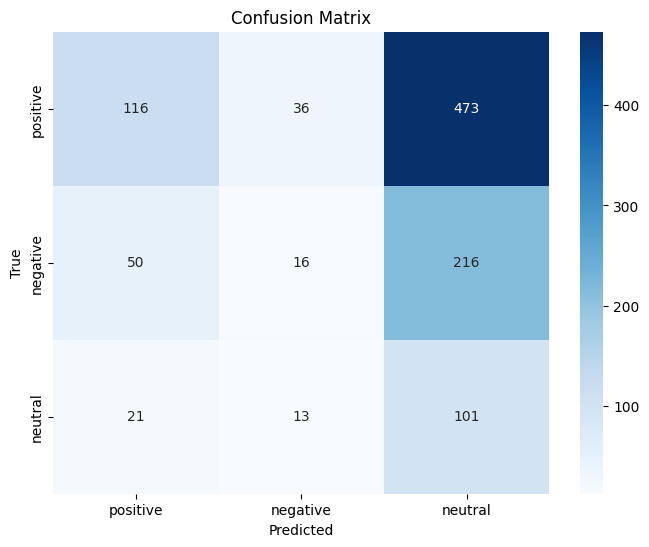

In [145]:
# Classification Report (includes F1, precision, recall per class + accuracy)
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=list(label_map.keys())))

# Individual Metrics
print(f"Accuracy: {accuracy_score(true_labels, preds):.4f}")
print(f"Weighted F1: {f1_score(true_labels, preds, average='weighted'):.4f}")
print(f"Macro F1: {f1_score(true_labels, preds, average='macro'):.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

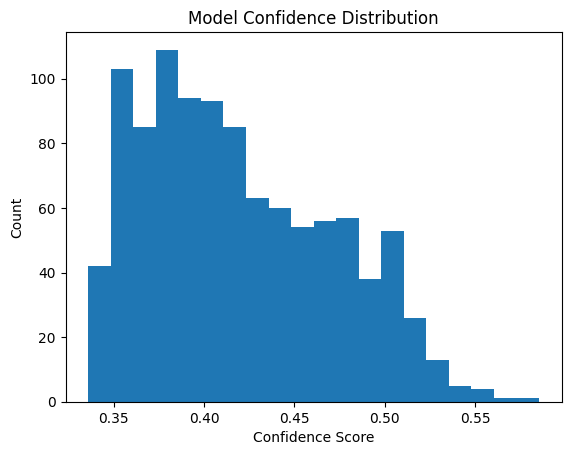

In [146]:
plt.hist(np.max(probs.numpy(), axis=1), bins=20)
plt.xlabel("Confidence Score")
plt.ylabel("Count")
plt.title("Model Confidence Distribution")
plt.show()

In [147]:

# Binarize labels for ROC AUC (only for binary/multiclass)
if len(label_map) == 2:  # Binary
    roc_auc = roc_auc_score(true_labels, predictions.predictions[:, 1])
    print(f"ROC AUC: {roc_auc:.4f}")
else:  # Multiclass (One-vs-Rest)
    y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
    roc_auc = roc_auc_score(y_true_bin, predictions.predictions, multi_class='ovr')
    print(f"ROC AUC (One-vs-Rest): {roc_auc:.4f}")

ROC AUC (One-vs-Rest): 0.5227


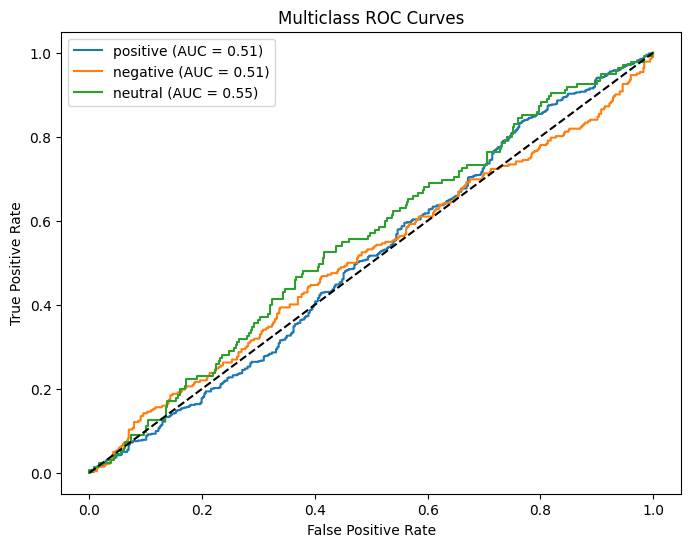

In [148]:
# Plot ROC curves for each class (multiclass)
if len(label_map) > 2:
    y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
    fpr, tpr, roc_auc = {}, {}, {}

    for i, class_name in enumerate(label_map.keys()):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions.predictions[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], predictions.predictions[:, i])

    plt.figure(figsize=(8, 6))
    for i in range(len(label_map)):
        plt.plot(fpr[i], tpr[i], label=f'{list(label_map.keys())[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend()
    plt.show()

In [149]:

# drive.mount('/content/drive')

# model.save_pretrained("/content/drive/MyDrive/AfroXLMR-Sesotho")
# afro_xmlr_tokenizer.save_pretrained("/content/drive/MyDrive/AfroXLMR-Sesotho")

# TF - IDF logistic regession model

In [150]:
X = sesotho_df['cleaned_sentence']
y = sesotho_df['Final_Label']

# Split data (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [151]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2),   # unigrams + bigrams
    max_features=5000
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [152]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [153]:
y_pred = clf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7900    0.6799    0.7308       603
           1     0.5185    0.5116    0.5151       301
           2     0.3628    0.5942    0.4505       138

    accuracy                         0.6200      1042
   macro avg     0.5571    0.5953    0.5655      1042
weighted avg     0.6550    0.6200    0.6314      1042



In [154]:

# Vectorize text
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# Train model
tfidf_model = LogisticRegression()
tfidf_model.fit(X_train_tfidf, y_train)

# Make predictions
tfidf_preds = tfidf_model.predict(X_test_tfidf)

## validation report

In [155]:
print(classification_report(y_test, tfidf_preds, digits=4))

              precision    recall  f1-score   support

           0     0.5889    0.9171    0.7173       603
           1     0.3529    0.1196    0.1787       301
           2     0.0000    0.0000    0.0000       138

    accuracy                         0.5653      1042
   macro avg     0.3140    0.3456    0.2986      1042
weighted avg     0.4428    0.5653    0.4667      1042



# STF-IDF BPE + logistic Regression

In [156]:
subword_bpe_tokenised_sentences = [" ".join(s) for s in sesotho_df['bpe_tokens']]

In [157]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    subword_bpe_tokenised_sentences, sesotho_df['Final_Label'], test_size=0.2, random_state=42
)

In [158]:
X = subword_bpe_tokenised_sentences
y = sesotho_df['Final_Label']

# Split data (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [159]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2),   # unigrams + bigrams
    max_features=5000
)

X_train_stfidf = vectorizer.fit_transform(X_train)
X_test_stfidf = vectorizer.transform(X_test)

In [160]:
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train_stfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [161]:
y_pred = clf.predict(X_test_stfidf)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7780    0.6915    0.7322       603
           1     0.4829    0.4684    0.4755       301
           2     0.3505    0.5435    0.4261       138

    accuracy                         0.6075      1042
   macro avg     0.5371    0.5678    0.5446      1042
weighted avg     0.6361    0.6075    0.6175      1042



In [162]:
stfidf_vectorizer = TfidfVectorizer()
X_train_stfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_stfidf = tfidf_vectorizer.transform(test_texts)

# Train model
stfidf_model = LogisticRegression()
stfidf_model.fit(X_train_stfidf, y_train)

# Make predictions
stfidf_preds = stfidf_model.predict(X_test_stfidf)

### validation report

In [163]:
print(classification_report(y_test, tfidf_preds, digits=4))

              precision    recall  f1-score   support

           0     0.5889    0.9171    0.7173       603
           1     0.3529    0.1196    0.1787       301
           2     0.0000    0.0000    0.0000       138

    accuracy                         0.5653      1042
   macro avg     0.3140    0.3456    0.2986      1042
weighted avg     0.4428    0.5653    0.4667      1042



# Comape f1 scores of target models

In [164]:
# F1 scores from classification reports
tfidf_f1 = classification_report(y_test, tfidf_preds, output_dict=True)
stfidf_f1 = classification_report(y_test, stfidf_preds, output_dict=True)
transformer_f1 = classification_report(y_test, preds, output_dict=True)

# Get weighted average F1 for each
f1_tfidf = tfidf_f1["weighted avg"]["f1-score"]
f1_stfidf = stfidf_f1["weighted avg"]["f1-score"]
f1_transformer = transformer_f1["weighted avg"]["f1-score"]

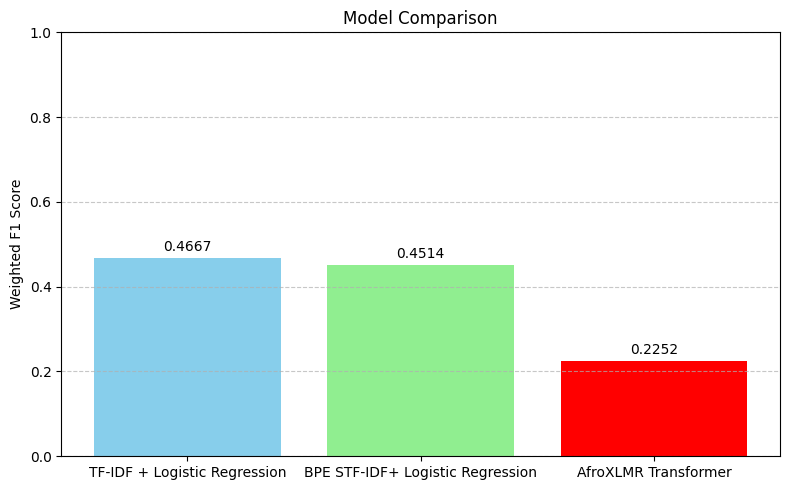

In [165]:
# Labels and scores
models = ['TF-IDF + Logistic Regression','BPE STF-IDF+ Logistic Regression', 'AfroXLMR Transformer']
scores = [f1_tfidf,f1_stfidf, f1_transformer]

# Bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores, color=['skyblue', 'lightgreen','red'])
plt.ylim(0, 1)
plt.ylabel('Weighted F1 Score')
plt.title('Model Comparison')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Neural model

In [166]:
class TweetClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TweetClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim * 128, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)              # (batch_size, seq_len, embed_dim)
        flat = embedded.view(x.size(0), -1)       # Flatten: (batch_size, seq_len * embed_dim)
        out = F.relu(self.fc1(flat))              # (batch_size, hidden_dim)
        return self.fc2(out)                      # (batch_size, output_dim)


In [167]:
def train_val_dataloader(encodings,data_labels):
  input_ids = encodings
  labels = data_labels

  dataset = TensorDataset(input_ids, labels)
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size

  train_ds, val_ds = random_split(dataset, [train_size, val_size])

  train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
  val_dl = DataLoader(val_ds, batch_size=32)

  return train_dl, val_dl

In [168]:
def train_eval_model(model, epochs,train_dl,val_dl):
    for epoch in range(epochs):
      model.train()
      total_loss = 0

      for xb, yb, in train_dl:
          preds = model(xb)
          loss = loss_fn(preds, yb)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    model.eval()
    correct, total = 0, 0

    predictions = []
    true_labels = []

    with torch.no_grad():
        for xb, yb in val_dl:
            preds = model(xb)
            predicted = torch.argmax(preds, dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)

            predictions.extend(predicted)
            true_labels.extend(yb)


    print(f"Validation Accuracy: {correct / total:.2%}")

    return predictions, true_labels


In [169]:
def metrics(predictions, true_labels):

  class_names = ['negative','positive','neutral']
  print("\n--- Full Classification Report ---")
  print(classification_report(true_labels, predictions, target_names=class_names, zero_division=0))
  return classification_report(true_labels, predictions, target_names=class_names, zero_division=0, output_dict=True)

## BPE model

In [170]:
model = TweetClassifier(vocab_size=bpe_tokenizer.vocab_size, embed_dim=128, hidden_dim=128, output_dim=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [171]:
train_dl, val_dl = train_val_dataloader(sesotho_bpe_encoding['input_ids'], torch.tensor(sesotho_df['Final_Label'].tolist()))
train_dl, val_dl = train_val_dataloader(sesotho_word_piece_encoding['input_ids'], torch.tensor(sesotho_df['Final_Label'].tolist()))

## evaluate model

In [172]:
predictions, true_labels = train_eval_model(model,1,train_dl,val_dl)

Epoch 1, Loss: 116.2266
Validation Accuracy: 59.79%


In [173]:
bpe_metrics = metrics(np.array(predictions),np.array(true_labels))


--- Full Classification Report ---
              precision    recall  f1-score   support

    negative       0.61      0.93      0.74       608
    positive       0.47      0.13      0.20       294
     neutral       0.47      0.14      0.21       140

    accuracy                           0.60      1042
   macro avg       0.52      0.40      0.38      1042
weighted avg       0.56      0.60      0.52      1042



# STF-idf + Nueral Model

In [174]:
class STFIDFClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(STFIDFClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        out = F.relu(self.fc1(x))
        return self.fc2(out)

In [175]:
sesotho_df

,sentence,Final_Label,predict_name,cleaned_sentence,bpe_tokens,word_piece_tokens,afro_xmlr_tokens
0,@user gwa tshwana rena ba bang a re kreye selo...,0,Sesotho,gwa tshwana rena ba bang a re kreye selo mos,"[▁gwa, ▁t, shwa, na, ▁rena, ▁ba, ▁bang, ▁a, ▁r...","[g, ##wa, ts, ##hwa, ##na, ren, ##a, ba, bang,...","[g, ##wa, ts, ##hwa, ##na, ren, ##a, ba, bang,..."
1,e bata goal spurs,2,Sesotho,e bata goal spurs,"[▁e, ▁bata, ▁goal, ▁, spur, s]","[e, bat, ##a, goal, spurs]","[e, bat, ##a, goal, spurs]"
2,@user @user ke nahana taba eno ea ho batla ho ...,0,multi,ke nahana taba eno ea ho batla ho khetha hoban...,"[▁ke, ▁na, hana, ▁taba, ▁en, o, ▁ea, ▁ho, ▁bat...","[ke, nah, ##ana, tab, ##a, en, ##o, ea, ho, ba...","[ke, nah, ##ana, tab, ##a, en, ##o, ea, ho, ba..."
3,@user lotho hle empa fela ke ipotela,1,Sesotho,lotho hle empa fela ke ipotela,"[▁lot, ho, ▁, hle, ▁emp, a, ▁fel, a, ▁ke, ▁i, ...","[lot, ##ho, h, ##le, em, ##pa, fe, ##la, ke, i...","[lot, ##ho, h, ##le, em, ##pa, fe, ##la, ke, i..."
4,@user @user keu utloa hantle,1,Sesotho,keu utloa hantle,"[▁ke, u, ▁ut, lo, a, ▁han, tle]","[ke, ##u, ut, ##lo, ##a, han, ##tle]","[ke, ##u, ut, ##lo, ##a, han, ##tle]"
...,...,...,...,...,...,...,...
5204,KOMPONE E NEHELANA KA KOLOI HO SEPOLESA,1,NaN,kompone e nehelana ka koloi ho sepolesa,"[▁kompon, e, ▁e, ▁ne, hela, na, ▁ka, ▁kolo, i,...","[ko, ##mp, ##one, e, ne, ##hel, ##ana, ka, ko,...","[ko, ##mp, ##one, e, ne, ##hel, ##ana, ka, ko,..."
5205,MOSEBETSI OA HO NEHELANA LE HO BULA SEMMUSO MO...,1,NaN,mosebetsi oa ho nehelana le ho bula semmuso mo...,"[▁mos, e, bet, si, ▁o, a, ▁ho, ▁ne, hela, na, ...","[mo, ##se, ##bet, ##si, o, ##a, ho, ne, ##hel,...","[mo, ##se, ##bet, ##si, o, ##a, ho, ne, ##hel,..."
5206,MOHLOMPHEHI TONAKHOLO O FIHLA SETEREKENG MOO A...,1,NaN,mohlomphehi tonakholo o fihla seterekeng moo a...,"[▁mohlo, m, phe, hi, ▁tona, kho, lo, ▁o, ▁fi, ...","[mo, ##hl, ##omp, ##he, ##hi, ton, ##akh, ##ol...","[mo, ##hl, ##omp, ##he, ##hi, ton, ##akh, ##ol..."
5207,KETEKELO EA KHOELI EA SEPOLESA,1,NaN,ketekelo ea khoeli ea sepolesa,"[▁kete, kel, o, ▁ea, ▁kho, eli, ▁ea, ▁se, pole...","[ke, ##tek, ##elo, ea, k, ##hoe, ##li, ea, sep...","[ke, ##tek, ##elo, ea, k, ##hoe, ##li, ea, sep..."


## N-gram

In [176]:

stfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=2)
stf_idf_matrix = stfidf_vectorizer.fit_transform(sesotho_df['sentence'])
stf_idf_vocab_size = len(stfidf_vectorizer.get_feature_names_out())

stf_idf_tensor = torch.tensor(stf_idf_matrix.toarray(), dtype=torch.float32)
print(stf_idf_tensor.shape)
print(stf_idf_vocab_size)

torch.Size([5209, 22255])
22255


In [177]:
train_dl, val_dl = train_val_dataloader(stf_idf_tensor, torch.tensor(sesotho_df['Final_Label'].tolist()))

In [178]:
model = STFIDFClassifier(input_dim=stf_idf_vocab_size, hidden_dim=128, output_dim=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [179]:
predictions, true_labels = train_eval_model(model,10,train_dl,val_dl)

Epoch 1, Loss: 116.6499
Epoch 2, Loss: 84.4384
Epoch 3, Loss: 56.1820
Epoch 4, Loss: 33.8699
Epoch 5, Loss: 20.7365
Epoch 6, Loss: 13.0824
Epoch 7, Loss: 8.5288
Epoch 8, Loss: 5.9030
Epoch 9, Loss: 4.2632
Epoch 10, Loss: 3.2913
Validation Accuracy: 66.31%


In [180]:
stf_idf_ngram_metrics = metrics(np.array(predictions),np.array(true_labels))


--- Full Classification Report ---
              precision    recall  f1-score   support

    negative       0.74      0.82      0.78       603
    positive       0.51      0.50      0.51       284
     neutral       0.56      0.34      0.42       155

    accuracy                           0.66      1042
   macro avg       0.60      0.56      0.57      1042
weighted avg       0.65      0.66      0.65      1042



## BPE

In [181]:
subword_bpe_tokenised_documnets = [" ".join(s) for s in sesotho_df['bpe_tokens']]
subword_bpe_tokenised_documnets[0:3]

['▁gwa ▁t shwa na ▁rena ▁ba ▁bang ▁a ▁re ▁kre ye ▁se lo ▁mos',
 '▁e ▁bata ▁goal ▁ spur s',
 '▁ke ▁na hana ▁taba ▁en o ▁ea ▁ho ▁bat la ▁ho ▁khe tha ▁ho bane ▁re ▁she bile ▁our ▁own ▁benefits ▁re ▁le ▁bat ho ▁ke ▁e ona ▁e ▁sent seng ▁polo tik i ▁ea ▁les ot ho ▁so ▁we ▁went ▁behind ▁as sho les ▁for ▁years ▁co z ▁re ▁she bile ▁mele mo ▁e ▁direct ▁rele ▁bat ho ▁a ▁ee a ▁sebe let sa ▁n']

In [182]:
stfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=2)
stf_idf_matrix = stfidf_vectorizer.fit_transform(subword_bpe_tokenised_documnets)
stf_idf_vocab_size = len(stfidf_vectorizer.get_feature_names_out())

stf_idf_tensor = torch.tensor(stf_idf_matrix.toarray(), dtype=torch.float32)
print(stf_idf_tensor.shape)
print(stf_idf_vocab_size)


torch.Size([5209, 11566])
11566


In [183]:
train_dl, val_dl = train_val_dataloader(stf_idf_tensor, torch.tensor(sesotho_df['Final_Label'].tolist()))

In [184]:
model = STFIDFClassifier(input_dim=stf_idf_vocab_size, hidden_dim=64, output_dim=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [185]:
predictions, true_labels = train_eval_model(model,10,train_dl,val_dl)

Epoch 1, Loss: 125.7647
Epoch 2, Loss: 100.3135
Epoch 3, Loss: 71.3270
Epoch 4, Loss: 46.5131
Epoch 5, Loss: 30.4411
Epoch 6, Loss: 19.4494
Epoch 7, Loss: 13.3952
Epoch 8, Loss: 9.6232
Epoch 9, Loss: 7.1974
Epoch 10, Loss: 5.6287
Validation Accuracy: 64.88%


In [186]:
stf_idf_bpe_metrics = metrics(np.array(predictions),np.array(true_labels))


--- Full Classification Report ---
              precision    recall  f1-score   support

    negative       0.71      0.82      0.76       613
    positive       0.51      0.46      0.48       290
     neutral       0.51      0.29      0.37       139

    accuracy                           0.65      1042
   macro avg       0.58      0.52      0.54      1042
weighted avg       0.63      0.65      0.63      1042



## Word piece

In [187]:
subword_word_piece_tokenised_documnets = [" ".join(s) for s in sesotho_df['word_piece_tokens']]
subword_word_piece_tokenised_documnets[0:3]

['g ##wa ts ##hwa ##na ren ##a ba bang a re k ##rey ##e se ##lo mo ##s',
 'e bat ##a goal spurs',
 'ke nah ##ana tab ##a en ##o ea ho bat ##la ho k ##het ##ha ho ##bane re she ##bil ##e our own benefits re le bath ##o ke e ##ona e sent ##sen ##g polo ##ti ##ki ea les ##otho so we went behind asshole ##s for years co ##z re she ##bil ##e mel ##em ##o e direct re ##le bath ##o a ee ##a se ##bel ##ets ##a n']

In [188]:
stfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=2)
stf_idf_matrix = stfidf_vectorizer.fit_transform(subword_word_piece_tokenised_documnets)
stf_idf_vocab_size = len(stfidf_vectorizer.get_feature_names_out())

stf_idf_tensor = torch.tensor(stf_idf_matrix.toarray(), dtype=torch.float32)
print(stf_idf_tensor.shape)
print(stf_idf_vocab_size)


torch.Size([5209, 11064])
11064


In [189]:
train_dl, val_dl = train_val_dataloader(stf_idf_tensor, torch.tensor(sesotho_df['Final_Label'].tolist()))

In [190]:
model = STFIDFClassifier(input_dim=stf_idf_vocab_size, hidden_dim=64, output_dim=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [191]:
predictions, true_labels = train_eval_model(model,10,train_dl,val_dl)

Epoch 1, Loss: 124.2678
Epoch 2, Loss: 98.8269
Epoch 3, Loss: 70.6780
Epoch 4, Loss: 46.2126
Epoch 5, Loss: 29.6061
Epoch 6, Loss: 19.5181
Epoch 7, Loss: 13.3117
Epoch 8, Loss: 9.5914
Epoch 9, Loss: 6.8565
Epoch 10, Loss: 5.2272
Validation Accuracy: 61.90%


In [192]:
stf_idf_word_piece_metrics = metrics(np.array(predictions),np.array(true_labels))


--- Full Classification Report ---
              precision    recall  f1-score   support

    negative       0.70      0.78      0.74       611
    positive       0.48      0.44      0.46       289
     neutral       0.43      0.28      0.34       142

    accuracy                           0.62      1042
   macro avg       0.54      0.50      0.51      1042
weighted avg       0.60      0.62      0.61      1042



## Comapare normal bpe and stf-idf models

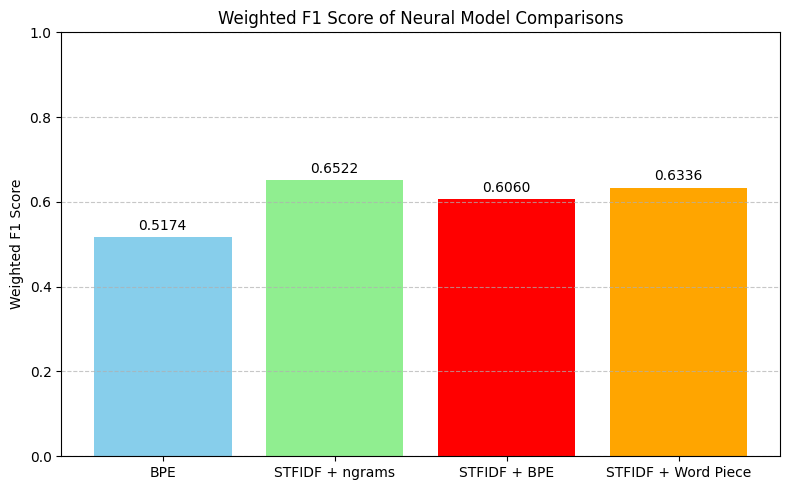

In [193]:
# Labels and scores
models_names = ['BPE', 'STFIDF + ngrams', 'STFIDF + BPE', 'STFIDF + Word Piece']
scores = [bpe_metrics["weighted avg"]["f1-score"],
stf_idf_ngram_metrics["weighted avg"]["f1-score"],
stf_idf_word_piece_metrics["weighted avg"]["f1-score"],
stf_idf_bpe_metrics["weighted avg"]["f1-score"]]

# Bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models_names, scores, color=['skyblue', 'lightgreen','red', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Weighted F1 Score')
plt.title('Weighted F1 Score of Neural Model Comparisons')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Large Classifier

In [194]:
class LargeSTFIDFClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LargeSTFIDFClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = F.relu(self.fc5(out))
        out = F.relu(self.fc6(out))
        return self.fc7(out)

In [195]:
subword_bpe_tokenised_documnets = [" ".join(s) for s in sesotho_df['bpe_tokens']]

In [196]:
train_dl, val_dl = train_val_dataloader(stf_idf_tensor, torch.tensor(sesotho_df['Final_Label'].tolist()))
stfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=2)
stf_idf_matrix = stfidf_vectorizer.fit_transform(subword_bpe_tokenised_documnets)
stf_idf_vocab_size = len(stfidf_vectorizer.get_feature_names_out())


# Convert to PyTorch tensor
stf_idf_tensor = torch.tensor(stf_idf_matrix.toarray(), dtype=torch.float32)

In [197]:
train_dl, val_dl = train_val_dataloader(stf_idf_tensor, torch.tensor(sesotho_df['Final_Label'].tolist()))

In [198]:

models = []
dims = [4]#[128,256]
epochs = [10,15,20]
lr = [1e-3, 3e-4, 3e-4,5e-4]

for dim in dims:
  for epoch in epochs:
    for l_r in lr:

      print(f"\ndim: {dim}, epochs: {epoch}, lr: {l_r}")

      model = LargeSTFIDFClassifier(input_dim=stf_idf_vocab_size, hidden_dim=dim, output_dim=3)
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=l_r)

      predictions, true_labels = train_eval_model(model,epoch,train_dl,val_dl)
      metric = metrics(np.array(predictions),np.array(true_labels))

      models.append({
          "dim": dim,
          "epoch": epoch,
          "lr": l_r,
          "metrics": metric
      })


dim: 4, epochs: 10, lr: 0.001
Epoch 1, Loss: 132.2086
Epoch 2, Loss: 127.8864
Epoch 3, Loss: 125.4532
Epoch 4, Loss: 124.1576
Epoch 5, Loss: 123.5621
Epoch 6, Loss: 123.2131
Epoch 7, Loss: 122.7919
Epoch 8, Loss: 122.7677
Epoch 9, Loss: 122.8809
Epoch 10, Loss: 122.7841
Validation Accuracy: 56.24%

--- Full Classification Report ---
              precision    recall  f1-score   support

    negative       0.56      1.00      0.72       586
    positive       0.00      0.00      0.00       300
     neutral       0.00      0.00      0.00       156

    accuracy                           0.56      1042
   macro avg       0.19      0.33      0.24      1042
weighted avg       0.32      0.56      0.40      1042


dim: 4, epochs: 10, lr: 0.0003
Epoch 1, Loss: 129.6128
Epoch 2, Loss: 127.6376
Epoch 3, Loss: 126.0335
Epoch 4, Loss: 124.6461
Epoch 5, Loss: 122.5422
Epoch 6, Loss: 113.6935
Epoch 7, Loss: 101.6924
Epoch 8, Loss: 89.4935
Epoch 9, Loss: 78.9018
Epoch 10, Loss: 70.4284
Validation Ac

## Best models comaparisons

In [199]:
#best 2 models by f1 score
best_models = sorted(models, key=lambda x: x['metrics']['weighted avg']['f1-score'], reverse=True)[:5]

print(len(best_models), "best models parameters")

#print best models
for i, model in enumerate(best_models):
    print(f"\nModel {i+1}:")
    print(f"Dimensions: {model['dim']}, Epochs: {model['epoch']}, Learning Rate: {model['lr']}")


5 best models parameters

Model 1:
Dimensions: 4, Epochs: 10, Learning Rate: 0.0003

Model 2:
Dimensions: 4, Epochs: 20, Learning Rate: 0.001

Model 3:
Dimensions: 4, Epochs: 20, Learning Rate: 0.0003

Model 4:
Dimensions: 4, Epochs: 15, Learning Rate: 0.0003

Model 5:
Dimensions: 4, Epochs: 20, Learning Rate: 0.0003


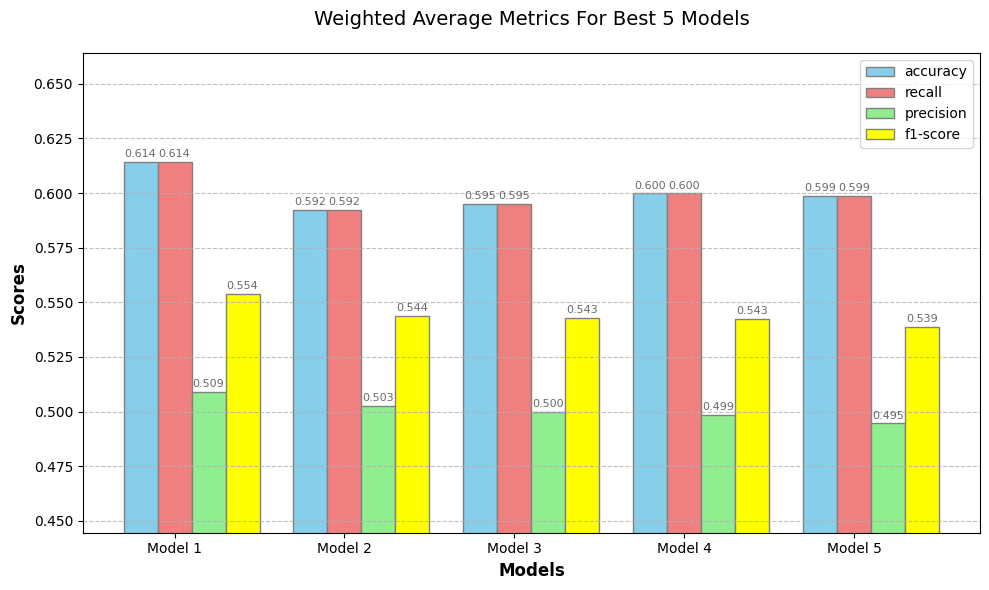

In [200]:
models_names = [F"Model {i+1}" for i in range(len(best_models))]
accuracy_scores = [model['metrics']['accuracy'] for model in best_models]
recall_scores = [model['metrics']['weighted avg']['recall'] for model in best_models]
precison_scores = [model['metrics']['weighted avg']['precision'] for model in best_models]
f1_scores = [model['metrics']['weighted avg']['f1-score'] for model in best_models]

bar_width = 0.2

r1 = np.arange(len(models_names))  # Positions for the first set of bars
r2 = [x + bar_width for x in r1] 
r3 = [x + bar_width * 2 for x in r1]
r4 = [x + bar_width * 3 for x in r1]

fig, ax = plt.subplots(figsize=(10, 6))


rects1 = ax.bar(r1, accuracy_scores, color='skyblue', width=bar_width, edgecolor='grey', label='accuracy')
rects2 = ax.bar(r2, recall_scores, color='lightcoral', width=bar_width, edgecolor='grey', label='recall')
rects3 = ax.bar(r3, precison_scores, color='lightgreen', width=bar_width, edgecolor='grey', label='precision')
rects4 = ax.bar(r4, f1_scores, color='yellow', width=bar_width, edgecolor='grey', label='f1-score')


ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Scores', fontweight='bold', fontsize=12)
ax.set_title('Weighted Average Metrics For Best 5 Models', fontsize=14, pad=20)


ax.set_xticks([r + bar_width for r in range(len(models_names))]) 
ax.set_xticklabels(models_names)

ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.8)

all_values = accuracy_scores + recall_scores + precison_scores + f1_scores
min_val = min(all_values)
max_val = max(all_values)

buffer = 0.05 
ymin = min_val - buffer
ymax = max_val + buffer

ax.set_ylim(ymin, ymax)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, color='dimgrey')
        
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()


# Evalutaions

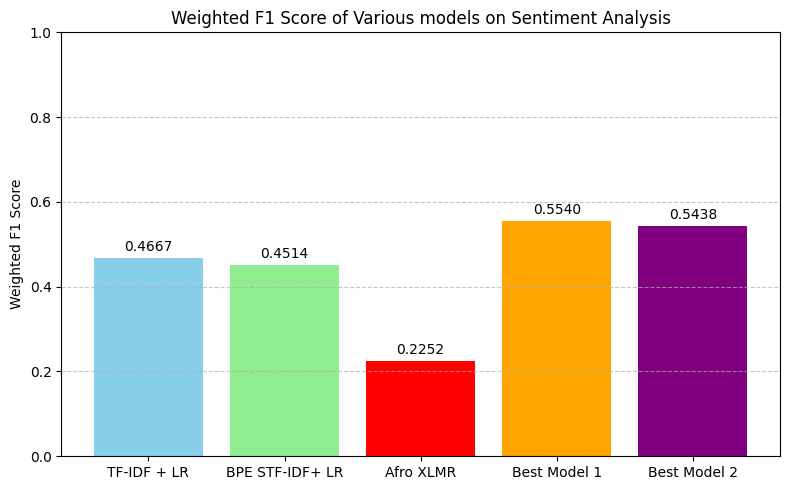

In [201]:
# Labels and scores
models_names = ['TF-IDF + LR','BPE STF-IDF+ LR','Afro XLMR', "Best Model 1","Best Model 2"]
scores = [f1_tfidf, f1_stfidf, f1_transformer, best_models[0]['metrics']['weighted avg']['f1-score'], best_models[1]['metrics']['weighted avg']['f1-score']]

# Bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models_names, scores, color=['skyblue', 'lightgreen','red', 'orange','purple'])
plt.ylim(0, 1)
plt.ylabel('Weighted F1 Score')
plt.title('Weighted F1 Score of Various models on Sentiment Analysis')

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()